[View in Colaboratory](https://colab.research.google.com/github/AvivSham/Reinforcement-Learning/blob/master/Kaggle's_Two_Sigma_Challenge.ipynb)

# `Two Sigma Financial Modeling Challenge`

---



In [18]:
#@title List the Dataset

# This is the most efficient way to load BigData to colab
# for small file you can use:
# from google.colab import files
# then you can use: files.upload()

from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/Kaggle_TwoSigma/train.h5"

Mounted at /content/drive
/content/drive/My Drive/Kaggle_TwoSigma/train.h5


In [0]:
#@title Convert the Dataset to Dataframe using pandas
!pip install --upgrade tables

import pandas as pd
import numpy as np

with pd.HDFStore("/content/drive/My Drive/Kaggle_TwoSigma/train.h5", "r") as train:
  df = train.get("train")


In [20]:
#@title Checking the size of the Dataset
print(df.shape)
print(len(df))

(1710756, 111)
1710756


In [21]:
#@title Viewing the Dataset
df.head()

,id,timestamp,derived_0,derived_1,derived_2,derived_3,derived_4,fundamental_0,fundamental_1,fundamental_2,...,technical_36,technical_37,technical_38,technical_39,technical_40,technical_41,technical_42,technical_43,technical_44,y
0,10,0,0.370326,-0.006316,0.222831,-0.213030,0.729277,-0.335633,0.113292,1.621238,...,0.775208,NaN,NaN,NaN,-0.414776,NaN,NaN,-2.0,NaN,-0.011753
1,11,0,0.014765,-0.038064,-0.017425,0.320652,-0.034134,0.004413,0.114285,-0.210185,...,0.025590,NaN,NaN,NaN,-0.273607,NaN,NaN,-2.0,NaN,-0.001240
2,12,0,-0.010622,-0.050577,3.379575,-0.157525,-0.068550,-0.155937,1.219439,-0.764516,...,0.151881,NaN,NaN,NaN,-0.175710,NaN,NaN,-2.0,NaN,-0.020940
3,25,0,NaN,NaN,NaN,NaN,NaN,0.178495,NaN,-0.007262,...,1.035936,NaN,NaN,NaN,-0.211506,NaN,NaN,-2.0,NaN,-0.015959
4,26,0,0.176693,-0.025284,-0.057680,0.015100,0.180894,0.139445,-0.125687,-0.018707,...,0.630232,NaN,NaN,NaN,-0.001957,NaN,NaN,0.0,NaN,-0.007338


In [0]:
#@title Checking labels and values
labels= []
values= []

for col in df.columns:
  labels.append(col)
  values.append(df[col].isnull().sum())
  print(col,values[-1])

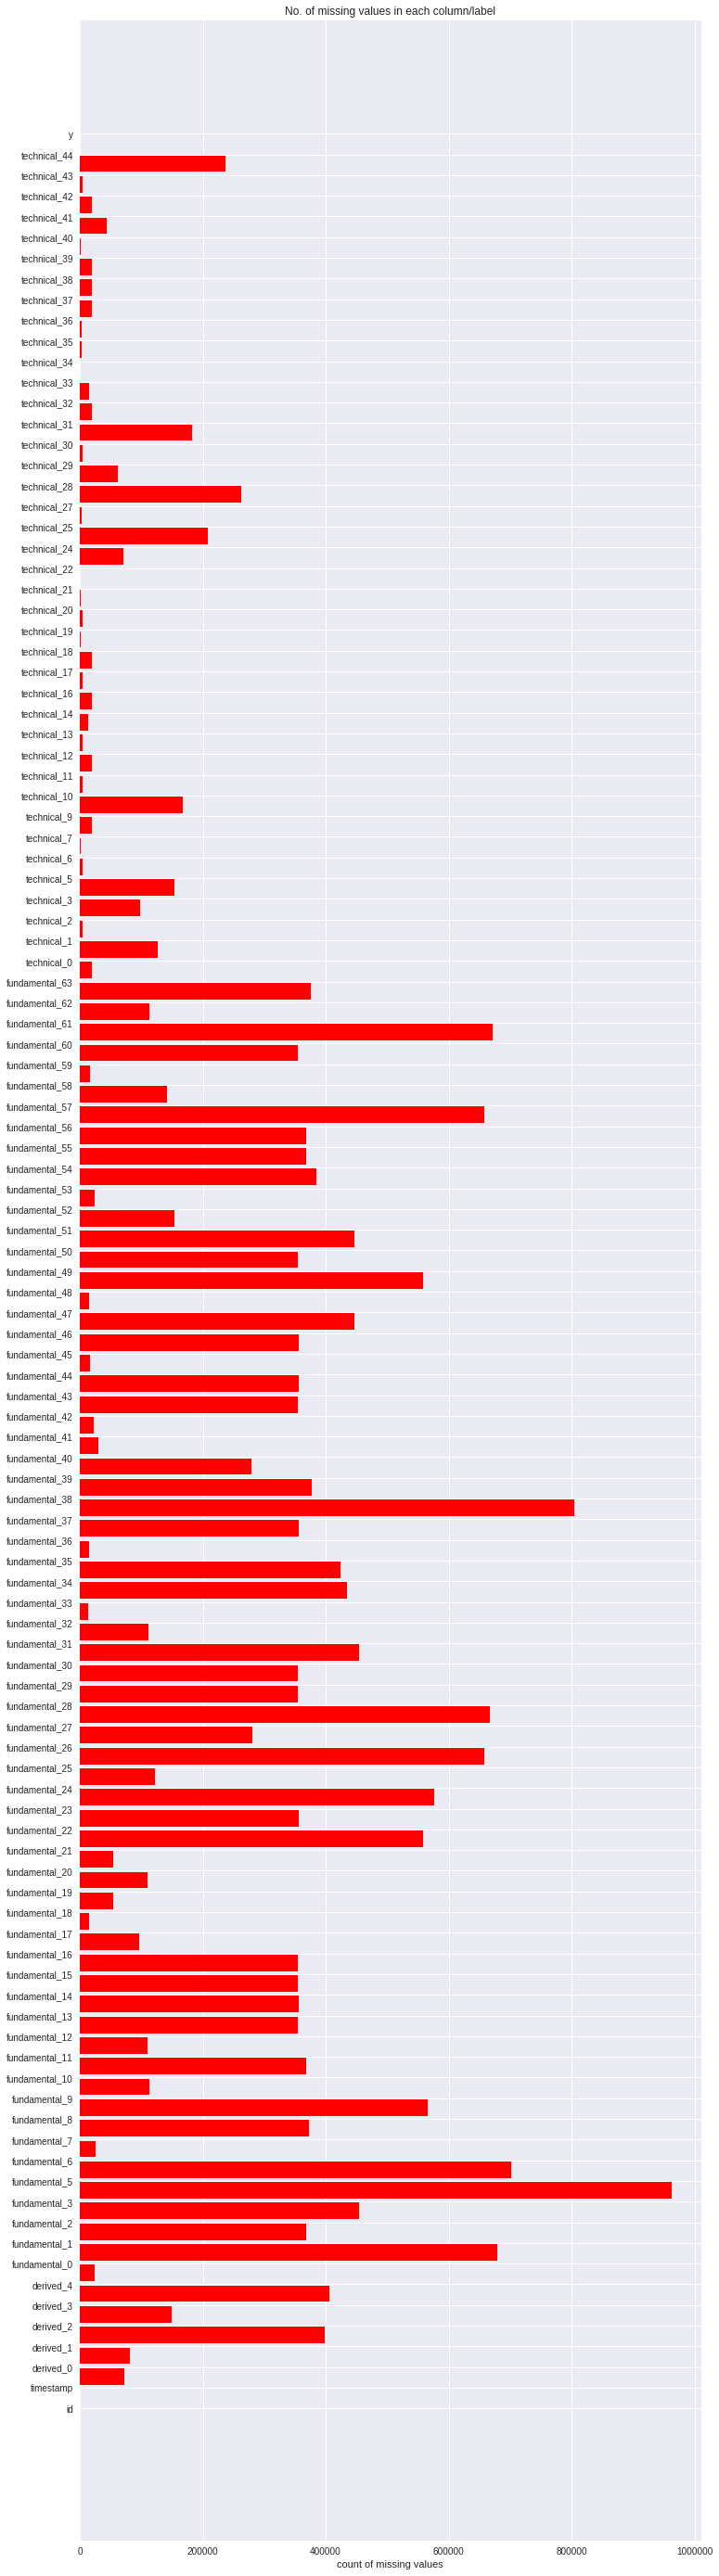

In [23]:
#@title Data cleaning - viewing the number of missing data
import matplotlib.pyplot as plt

%matplotlib inline

ind = np.arange(len(labels))
width = 0.9
fig , ax = plt.subplots (figsize=(12,50))
rects = ax.barh(ind, np.array(values), color='r')
ax.set_yticks(ind+(width)/2.)
ax.set_yticklabels(labels, rotation = 'horizontal')
ax.set_xlabel("count of missing values")
ax.set_title("No. of missing values in each column/label")
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


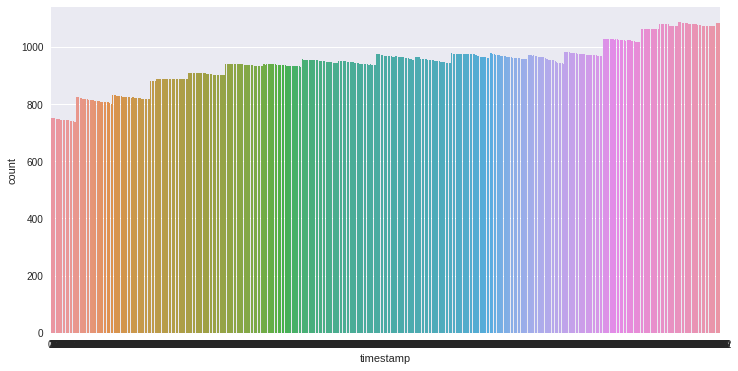

In [24]:
#@title Counts for each timestep in the Dataset
import seaborn as sns

fig = plt.figure(figsize=(12,6))
sns.countplot(x='timestamp', data=df)
plt.show()

In [25]:
#@title Unique Assets
print(len(df.id.unique()))

1424


In [0]:
#@title Import libraries and definnig the loss function of the agent
import os
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score

# This is taken from Frans Slothoubers post on kaggle.
# The purpose is to format the problem as an MDP and optimize it.

def r_score(y_true, y_pred, sample_weight=None, multioutput=None):
    r2 = r2_score(y_true, y_pred, sample_weight=sample_weight,
                  multioutput=multioutput)
    r = (np.sign(r2)*np.sqrt(np.abs(r2)))
    if r <= -1:
        return -1
    else:
        return r

In [0]:
class Observation(object):
    def __init__(self, train, target, features):
        self.train = train
        self.target = target
        self.features = features


class Environment(object):
    def __init__(self):
        with pd.HDFStore("/content/drive/My Drive/Kaggle_TwoSigma/train.h5", "r") as hfdata:
            self.timestamp = 0
            fullset = hfdata.get("train")
            self.unique_timestamp = fullset["timestamp"].unique()
            # Get a list of unique timestamps
            # use the first half for training and
            # the second half for the test set
            n = len(self.unique_timestamp)
            i = int(n/2)
            timesplit = self.unique_timestamp[i]
            self.n = n
            self.unique_idx = i
            self.train = fullset[fullset.timestamp < timesplit]
            self.test = fullset[fullset.timestamp >= timesplit]

            # Needed to compute final score
            self.full = self.test.loc[:, ['timestamp', 'y']]
            self.full['y_hat'] = 0.0
            self.temp_test_y = None

    def reset(self):
        timesplit = self.unique_timestamp[self.unique_idx]

        self.unique_idx = int(self.n / 2)
        self.unique_idx += 1
        subset = self.test[self.test.timestamp == timesplit]

        # reset index to conform to how kagglegym works
        target = subset.loc[:, ['id', 'y']].reset_index(drop=True)
        self.temp_test_y = target['y']
        
        target.loc[:, 'y'] = 0.0  # set the prediction column to zero

        # changed bounds to 0:110 from 1:111 to mimic the behavior
        # of api for feature
        features = subset.iloc[:, :110].reset_index(drop=True)

        observation = Observation(self.train, target, features)
        return observation

    def step(self, target):
        timesplit = self.unique_timestamp[self.unique_idx-1]
        # Since full and target have a different index we need
        # to do a _values trick here to get the assignment working
        y_hat = target.loc[:, ['y']]
        self.full.loc[self.full.timestamp == timesplit, ['y_hat']] = y_hat._values

        if self.unique_idx == self.n:
            done = True
            observation = None
            reward = r_score(self.temp_test_y, target.loc[:, 'y'])
            score = r_score(self.full['y'], self.full['y_hat'])
            info = {'public_score': -score}
        else:
            reward = r_score(self.temp_test_y, target.loc[:, 'y'])
            done = False
            info = {}
            timesplit = self.unique_timestamp[self.unique_idx]
            self.unique_idx += 1
            subset = self.test[self.test.timestamp == timesplit]

            # reset index to conform to how kagglegym works
            target = subset.loc[:, ['id', 'y']].reset_index(drop=True)
            self.temp_test_y = target['y']

            # set the prediction column to zero
            target.loc[:, 'y'] = 0
            # column bound change on the subset
            # reset index to conform to how kagglegym works
            features = subset.iloc[:, 0:110].reset_index(drop=True)

            observation = Observation(self.train, target, features)

        return observation, reward, done, info

    def __str__(self):
        return "Environment()"

In [0]:
#@title Agent optimization loop
def make():
  return Environment()

def test():
  # Create environment
  env=make() 
  observation = env.reset()
  
  print(len(observation.target))
  print(len(observation.train))
  
  
  n=0
  
  rewards = []
  
  while True:
    target = observation.target
    target.loc[:,'y'] = 0.0006
    observation, reward, done, info = env.step(target)
    if done:
      break
    rewards.append(reward)
    n = n+1
    
  print(info)
  print(n)
  print(rewards[0:15])
    

In [33]:
#@title Testing the agent
test()

968
806298
{'public_score': 0.017829389044606993}
906
[-0.15367924219682547, -0.026140842058380256, -0.11231466648997339, -0.1682864647754967, -0.02167206673334583, -0.08693960274478746, -0.30473984896980755, -0.09382985372389648, -0.09945405540987054, -0.05014964521079367, -0.14505984849997253, -0.19402383221313182, -0.0017121406664662242, -0.01388272905431911, -0.2019392220527433]
